In [ ]:
cd ~/Desktop/DeepLearningPilot/

In [177]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from skimage import filters,morphology,measure,exposure,feature
from scipy.stats import pearsonr
import seaborn as sns
from ncolor import label
from timeit import default_timer
import pickle as pk, glob, os
import momia2 as mo
from ncolor import label
import tifffile

In [119]:
from skimage.feature import peak_local_max

In [72]:
traj = pk.load(open('/Volumes/JZSSD_temp/20190709_NQTF/2_tracking_plots/NQTF_bleb_trajectory.pk','rb'))

In [115]:
img = tifffile.imread('/Volumes/JZSSD_temp/20190709_NQTF/driftcorrected_13.tif')

In [108]:
subset = traj[traj['Image_id']=='13'].copy()
filtered = subset.copy()

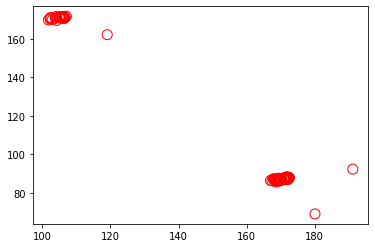

In [260]:
weirdo = []
x0=1300
y0=1200
h,w = 300,300
mask = np.zeros((h,w))
mask[155:195,80:130]=1
mask[50:100,150:200]=1
for i in range(80):
    crop=img[i,0,x0:x0+h,y0:y0+w]
    smoothed = filters.gaussian(crop,sigma=2,preserve_range=True)
    log = mo.utils.fish_utils.find_puncta(smoothed,mask,threshold_rel=0.8)
    if len(log)>0:
        log = log[log[:,2]>950]
        if len(log)>0:
            df=pd.DataFrame()
            _x,_y,_v,_l = log.T
            plt.scatter(_y,_x,s=100,fc='None',ec='r')
            df['x'] = _x+x0
            df['y'] = _y+y0
            df['frame'] = i
            weirdo.append(df)
weirdo = pd.concat(weirdo)

In [242]:
log = feature.blob_log(smoothed[100:,:-100], min_sigma=0.1,max_sigma=3, num_sigma=5, 
                       threshold=0.002,threshold_rel=0.15)

In [243]:
_x,_y,_p=log.T

In [244]:
_x

array([186., 271., 345.])

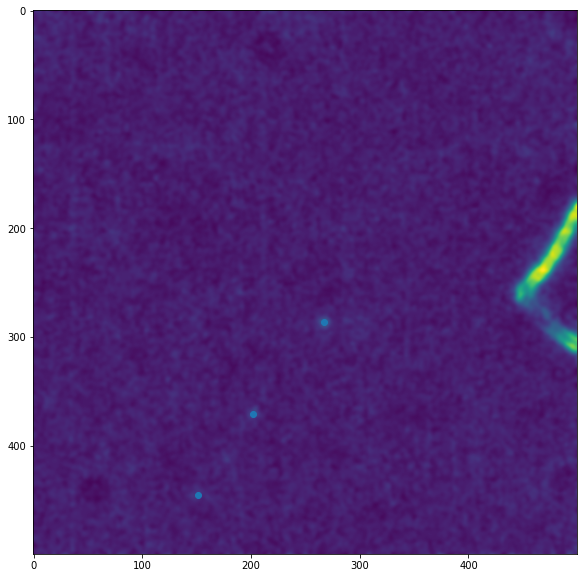

In [245]:
fig=plt.figure(figsize=(10,10))
plt.imshow(smoothed)
plt.scatter(_y,_x+100)

In [169]:
cell_dict = {}
t_dict = {}
for c in filtered['Unique_id'].unique():
    event = filtered[filtered['Unique_id']==c].copy()
    x=event['x'].values
    y=event['y'].values
    t=event['$time'].values
    l=len(event)
    cell_dict[c] = [l,t,x,y]
    for st in t:
        if st not in t_dict:
            t_dict[st] = [c]
        else:
            t_dict[st] += [c]

In [261]:
from matplotlib.collections import LineCollection
from matplotlib import cm
norm = plt.Normalize(0,1)

x0=1100
y0=1100
for t in range(80):
    fig,axes=plt.subplots(figsize=(8.1,4),ncols=2,gridspec_kw={'wspace':0})
    h=w=500
    axes[0].imshow(img[t,0,x0:x0+500,y0:y0+500],cmap='gist_gray',vmin=550,vmax=1800)
    axes[1].imshow(img[t,0,x0:x0+500,y0:y0+500],cmap='gist_gray',vmin=550,vmax=1800)
    axes[0].axis('off')
    axes[1].axis('off')
    
    if t in t_dict:
        for c in t_dict[t]:
            l,ts,x,y = cell_dict[c]
            id_series = np.where(ts<=t)[0]
            axes[1].scatter(y[id_series[-1]]-x0,x[id_series[-1]]-x0,color=cm.get_cmap('viridis')(len(id_series)/l),s=3)
            if len(id_series)>0:
                points = np.array([y[id_series]-y0,x[id_series]-x0]).T.reshape(-1, 1, 2)
                segments = np.concatenate([points[:-1], points[1:]], axis=1)
                lc = LineCollection(segments,
                                cmap='viridis',
                                norm=norm)
                lc.set_array(np.linspace(0,len(id_series)/l,len(id_series)))
                lc.set_linewidth(1.5)
                line = axes[1].add_collection(lc)
    
    weirdo_frame = weirdo[weirdo['frame']==t].copy()
    if len(weirdo_frame)>0:
        _x = weirdo_frame['x']-x0
        _y = weirdo_frame['y']-y0
        axes[1].scatter(_y,_x,fc='None',ec='r',s=50)
    axes[1].set_xlim(0,500)
    axes[1].set_ylim(500,0)
    axes[0].text(0.05,0.95,'{} hours'.format(round(t*0.25,2)),transform=axes[0].transAxes,
                  ha='left',va='top',zorder=3,color='w',fontsize=18,fontweight='bold',fontname='Arial')
    axes[0].plot([(0.05*w),(0.05*w)+(5/0.065)],[0.9*h,0.9*h],color='w',lw=8)
    plt.savefig('/Volumes/JZSSD_temp/20190709_NQTF/2_tracking_plots/RIF_blob_tracking/{}.png'.format(t),dpi=200,
                bbox_inches='tight')
    plt.close()
#filtered

In [ ]:
for x in image_data['Unique_id']:
subset = image_data[image_data['Unique_id']==x].copy()
if len(subset)==1:
    plt.scatter(subset['y'].values[0],
                subset['x'].values[0],
                color=cm.get_cmap('viridis')(0),s=2)
else:
    x=subset['y'].values
    y=subset['x'].values
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments,
                        cmap='viridis',
                        norm=norm)
    lc.set_array(np.linspace(0,1,len(subset)))
    lc.set_linewidth(1.5)
    line = ax.add_collection(lc)

In [ ]:
fl_bg_removed=mo.utils.correction.rolling_ball_bg_subtraction(img[t,0])[200:700,200:700]

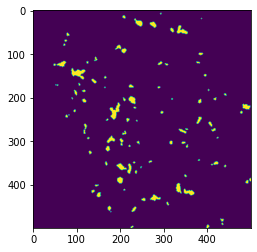

In [60]:
plt.imshow(morphology.binary_opening(morphology.remove_small_objects(measure.label(fl_bg_removed>750),10)>0))

In [65]:
for idx in ['01','03','04','07','08','09','12','13','14']:
    k = '/Volumes/JZSSD_temp/20190709_NQTF/driftcorrected_{}.tif'.format(idx)
    fname = k.split('.tif')[0]+'_qtfBlob.pk'
    if not os.path.isfile(fname):
        img = tifffile.imread(k)
        merged_df = []
        for i in range(90):
            fl = img[i,0]
            fl_bg_removed=mo.utils.correction.rolling_ball_bg_subtraction(fl)
            fl_blob_mask = (fl_bg_removed>750)*1
            if fl_blob_mask.sum()>0:
                labeled = measure.label(fl_blob_mask)
                filtered = morphology.remove_small_objects(labeled,min_size=10)
                if filtered.max()>0:
                    df = mo.metrics.get_regionprop(filtered,fl_bg_removed)
                    df['$centroid'] = [np.mean(coords,axis=0) for coords in df['$coords']]
                    df['$time'] = i
                    merged_df.append(df)
        merged_df = pd.concat(merged_df)
        pk.dump(merged_df,open(fname,'wb'))

/Users/jz-rolling/opt/anaconda3/envs/keras_pilot/lib/python3.8/site-packages/skimage/_shared/utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)


In [262]:
# render movies
import cv2
f = '/Volumes/JZSSD_temp/20190709_NQTF/2_tracking_plots/RIF_blob_tracking/'
header = f.split('/')[-2]
frames = []

for i in range(30,80):
    p = f+'{}.png'.format(i)
    img = cv2.imread(p)
    height, width, _c = img.shape
    frames.append(img)
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
out2 = cv2.VideoWriter('/Volumes/JZSSD_temp/20190709_NQTF/2_tracking_plots/{}.avi'.format(header),
                        fourcc, fps=6, frameSize=np.flip(img.shape[:2])) 
for i in range(len(frames)):
    out2.write(frames[i])
out2.release()